## Recommender system design [WIP]
1. using faiss vectorstore, return 100 images
2. using faiss identified images, get prompts from metadata
    - rank 100 prompts for similarity with local vocab
3. using faiss identified images, get tags from metadata
    - rank 100 tag sets for similarity with local vocab
4. Return 20 images to user
    - return top 15 MOST similar images
    - return 5 randomly selected images from index 15-50

In [1]:
import os, time, faiss, json, torch, sys

sys.path.append('../utils/')
from local_utils import get_recommendations_dino, save_similarity_plots, get_text_vectors, get_local_cosine_sim, get_similarity_rank_dictionary, get_keys_for_recommendations

import numpy as np
from PIL import Image
from torchvision import transforms as tfms

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" ##Without this the jupyter kernel will crash. It crashes because of too many OMP instances running, however this prevents that

c:\Users\wolfg\OneDrive\Documents\CivitAI\Project Work\ViTImageRecommender\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### MetaData Filters
In this notebook we'll explore using FAISS to return top 100 images, and then filtering down further by tags, rating levels, and prompts. We can also filter so similar models/basemodels

## To Do:
1. Check filtering with cosine distance rather than Euclidian
    - the distance isn't truly cosine, but rather some similar like computation
    - Both forms of the index return the same images
    - since distances are not bounded as we'd expect, we'll utilize the original index 
2. Get local prompt vocab/similarity
3. Get local tag similarity
4. Get same by Model
5. get some randos
6. Return top 20 similar images
7. Grab the 20th image and get the next top 20 images

In [2]:
metadata_file = '../data/metadata.json'

faiss_index = faiss.read_index("../data/image_index_vit.index")

with open(metadata_file, 'r') as f:
    metadata = json.load(f)

In [3]:
# Load the pre-trained ViT model
model = torch.hub.load('facebookresearch/dino:main', 'dino_vits16')

# Define preprocessing pipeline for images
transform = tfms.Compose([
    tfms.Resize(256),
    tfms.CenterCrop(224),
    tfms.ToTensor(),
    tfms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Using cache found in C:\Users\wolfg/.cache\torch\hub\facebookresearch_dino_main


To test this, we need an image we have metadata for. So we'll kind of cheese a part of this and get an image from our database

we'll get entry `metadata[10188]`

## get top 100 images

In [4]:
test_image_dict = metadata['10188']
metadata.pop('10188')

{'image_id': 11234585,
 'url': '2a44dabb-c38d-40e9-a951-c0fb514e30ff',
 'created_at': '2024-05-01 08:17:24.904000',
 'prompt': '<lora:sdxl_lightning_8step_lora:1>, dark focused flash photo, amazing quality, masterpiece, best quality, hyper detailed, ultra detailed, UHD, slavenian girl, small breast 1 size, beautiful lips, bea\x043tiful blue eyes, expressive clear eyes, tender bare abs, sexy long beautiful legs, translucent energy burst wings sexy fairy princess fluttering around and blending with the surroundings in a long flowing wavy felt dress, high fantasy image of an ethereal magical forest, glowing flowers and bioluminescent trees, distant waterfall, serene ambiance',
 'model': None,
 'original_level': 'PG13',
 'tags': 'wings, waterfall, water, strapless, solo, nature, medium breasts, looking at viewer, long hair, flower, dress, breasts, blue eyes, blonde hair, revealing clothes, partially exposed female breast, non-explicit nudity, non-explicit nudity of intimate parts and kissi

Runtime: 0.19787883758544922 seconds for retrieving recommendations


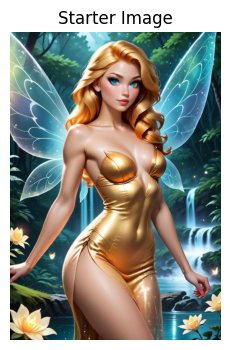

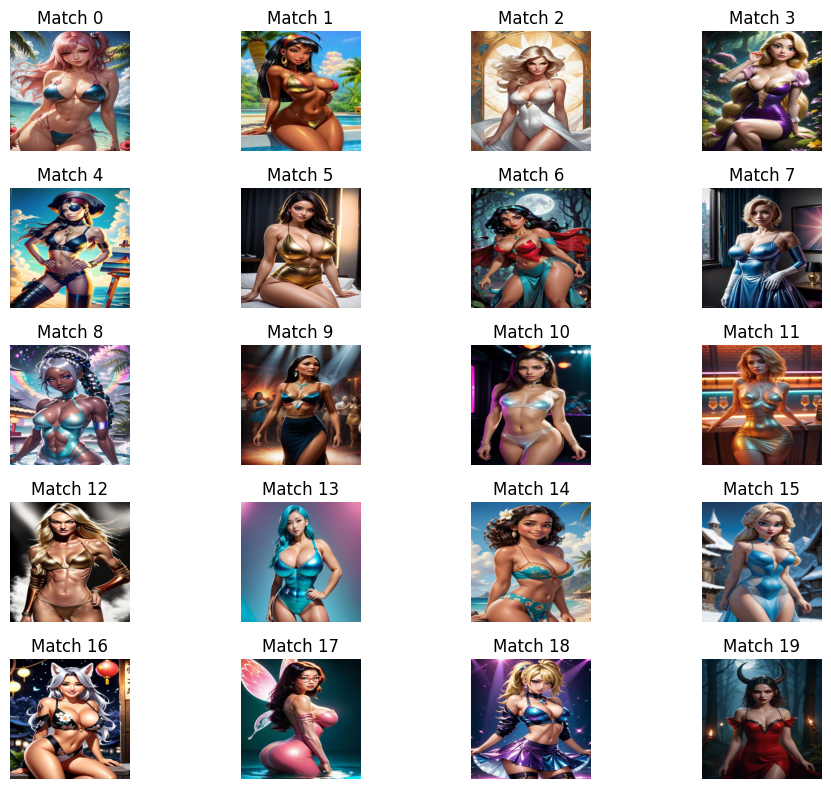

In [5]:
start_time = time.time()

test_img_path = os.path.join('../data/imgs', str(test_image_dict['image_id'])+'.jpg')
test_img = Image.open(test_img_path)

distances, indices = get_recommendations_dino(test_img, faiss_index, model, transform, 101)

# End the timer
end_time = time.time()
# Calculate the runtime
##Only do this during this testing
distances = np.delete(distances, 0, axis=1)
indices = np.delete(indices, 0, axis=1)
runtime = end_time - start_time

# Print the runtime
print(f"Runtime: {runtime} seconds for retrieving recommendations")
save_similarity_plots(4, 5, test_image_dict, '../data/imgs/', metadata, indices, '../data/results/', 'dino')

Using indices, get
1. Prompt Similarities
2. Tag Similarities
3. Rank Similarities

In [6]:
if test_image_dict['prompt'] != 'None':
    prompt_vectors = get_text_vectors(test_image_dict, list(indices[0]), metadata)
else:
    prompt_vectors = {indices[0][i]: [0] for i in range(len(indices[0]))}
    prompt_vectors['starter_prompt'] = [0]
    
tag_vectors = get_text_vectors(test_image_dict, list(indices[0]), metadata, 'tags')
sorted_prompt_cosine_dict = get_local_cosine_sim(prompt_vectors)
sorted_tag_cosine_dict = get_local_cosine_sim(tag_vectors)

rank_dictionary = get_similarity_rank_dictionary(indices, distances, sorted_prompt_cosine_dict, sorted_tag_cosine_dict)

recommended_keys = get_keys_for_recommendations(rank_dictionary)

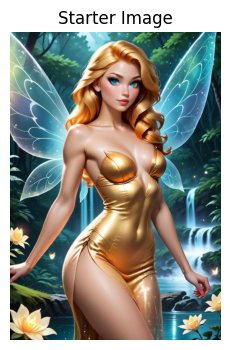

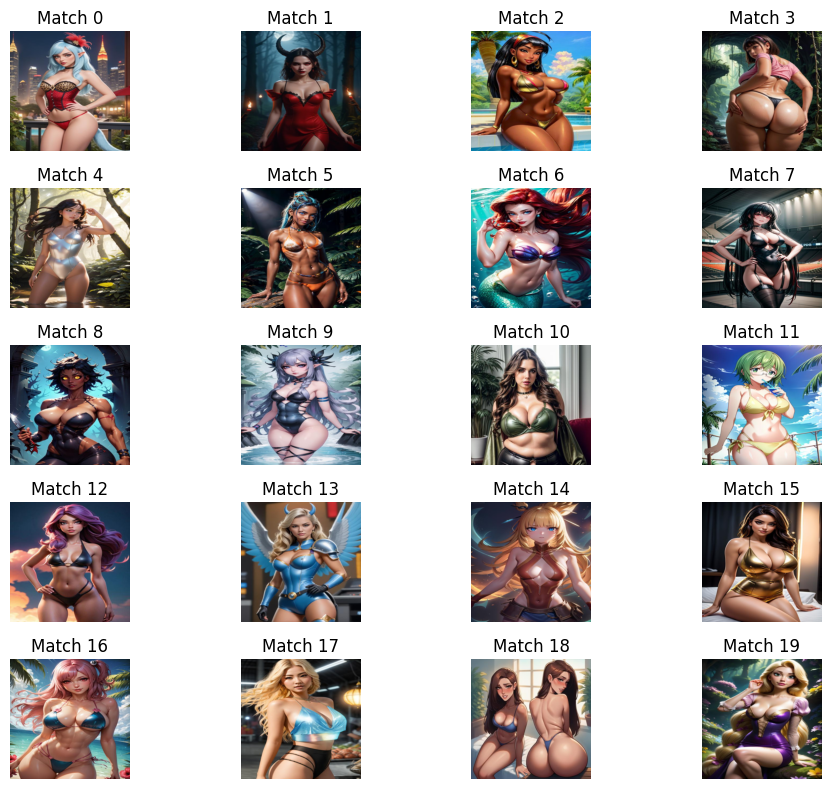

In [7]:
save_similarity_plots(4, 5, test_image_dict, '../data/imgs/', metadata, [k for k in sorted_prompt_cosine_dict.keys()], '../data/results/', 'Prompt')

## Plot Images based on Tag Similarities

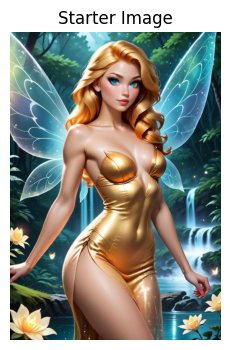

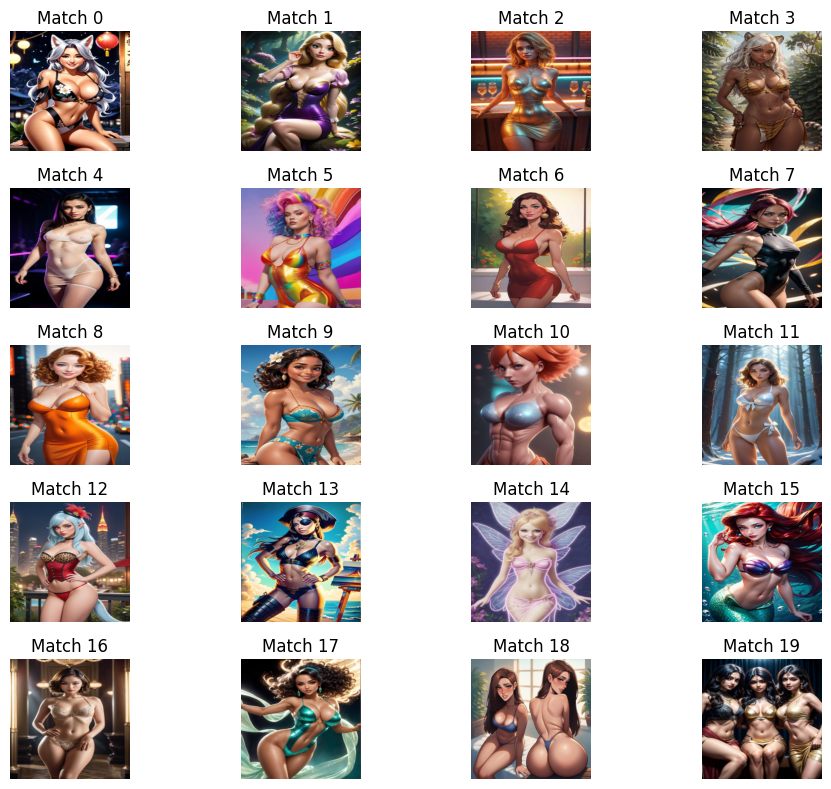

In [8]:
save_similarity_plots(4, 5, test_image_dict, '../data/imgs/', metadata, [k for k in sorted_tag_cosine_dict.keys()], '../data/results/', 'Tag')

## Plot Images based on Rank Similarities

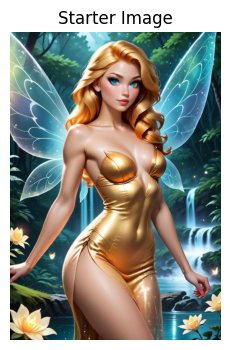

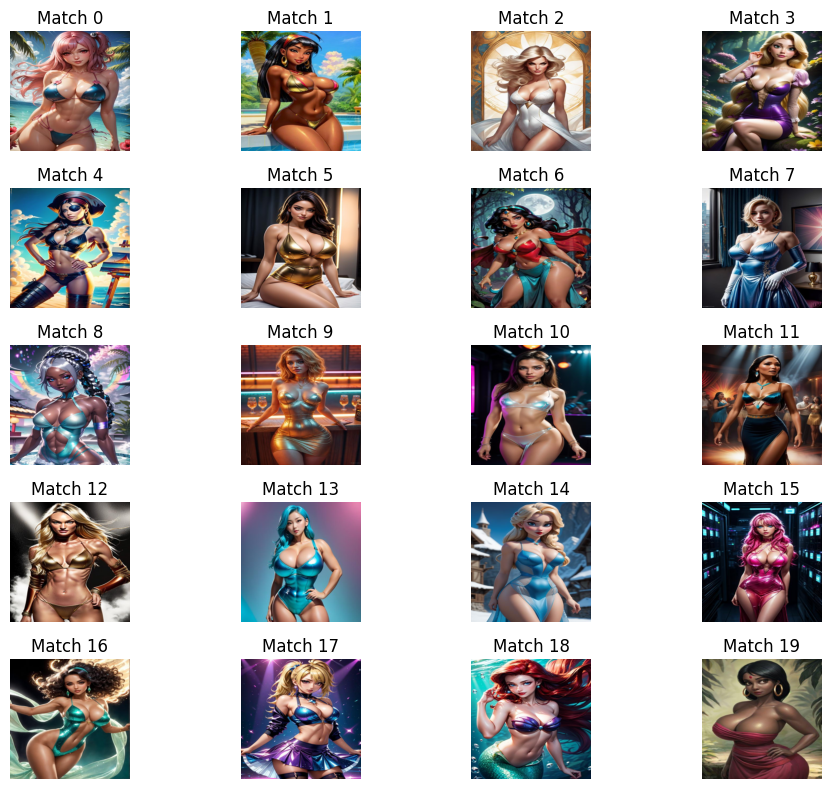

In [9]:
save_similarity_plots(4, 5, test_image_dict, '../data/imgs/', metadata, recommended_keys, '../data/results/', 'Tag')